#  Introduction 

L'objectif de ce TP est de générer un processus de Poisson pour simuler le comportement des stations de base, notamment en traçant selon certaines hypothèses une carte de SIR. On rajoutera par la suite des utilisateurs afin de comparer l'impact sur la carte de SIR. 

Le language de programmation utilisé sera Python. Le support du rapport est un Jupyter Notebook qui a la particularité de combiner des bouts de code que l'on peut lancer dans des cellules, et du texte en Markdown pour écrire du texte ou des équations avec le langage de _Latex_.

J'ai choisi de reprogrammer les fonctions de génération de processus à partir de la génération de variables aléatoires suivant des lois uniformes. Ainsi, il se peut que cela prenne plus de temps que d'utiliser les fonctions déjà implémentées dans la bibliothèque _NumPy_ 

Des détails sur la fonction pour tracer le pavage de Voronoï sur Python sont données en annexe.


_Attention : Il est préférable de lancer la cellule de code en annexe pour pouvoir lancer tout le reste sans bug._

_Autre conseil : Du fait de la mise à l'échelle en fonction des plages de valeurs, les graphes et les cartes générés ne sont pas forcément comparables à l'oeil. Ceci est lié à un formatage de Jupyter Notebook pour la génération de graphe par le code d'une cellule. Il s'agit de bien regarder les axes et les graduations associées à chaque visualisation graphique._



# Processus de Poisson

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def nb_poisson(lbda, a):
    u = np.random.rand()
    x = - 1 / (lbda * a**2) * np.log(u)
    k = 1
    somme = x
    while somme <= 1:
        u = np.random.rand()
        x = - 1 / (lbda * a**2) * np.log(u)
        k = k + 1
        somme = somme + x
    n = k - 1
    return n
    

def proc_poisson(lbda, a):
    N = nb_poisson(lbda, a)
    x = np.zeros((N,2))
    for i in range(N):
        x[i,:] = a * np.random.rand(2)
    return x    

**1)** Simulation de stations répartis selon un processus de Poisson dans une surface carrée. 

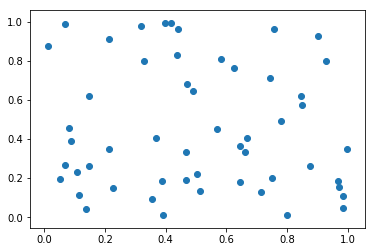

In [4]:
stations = proc_poisson(50,1)
plt.scatter(stations[:,0],stations[:,1])
plt.show()

> **2)**

In [5]:
def nb_moyen_poisson(nb_iter, lbda, a):
    mean = 0
    for i in range(nb_iter):
        mean += nb_poisson(lbda, a)
    return mean / nb_iter

In [6]:
nb_moyen_poisson(nb_iter = 100,lbda = 50,a = 1)

49.51

Ceci correspond bien à ce que l'on attend à savoir une approximation de $\lambda$, en vertu de la loi des grands nombres. 

**3)** On calcule la distance moyenne ainsi que l'erreur commise par rapport à la formule théorique.

In [7]:
def mean_dist_neighbour(points, a):
    # grid as a ndarray
    n = points.shape
    dist = np.zeros(n[0])
    for i in range(n[0]):
        d = 2 * a
        for j in range(n[0]):
            if j != i:
                distance = np.linalg.norm(points[j,:] - points[i,:])
                if distance < d:
                    d = distance
        dist[i] = d
    return(np.mean(dist))

In [8]:
mean_dist_neighbour(stations,1)

0.08197376045824689

In [9]:
stations = proc_poisson(50, 1)
mean_dist_neighbour(stations, 1)

0.06451295630319012

In [10]:
# la valeur théorique
D = 1 / (2 * np.sqrt(50))
D

0.07071067811865475

In [11]:
def error_mean(nb_iter, fun, proc, a, lbda):
    D = 1 / (2 * np.sqrt(lbda))
    error = 0
    for i in range(nb_iter):
        error += (fun(proc, a) - D)**2
    return np.sqrt(error / nb_iter)

In [12]:
error_mean(50, mean_dist_neighbour, stations, 1, 50)

0.00619772181546463

**4)** On retouve les résultats théoriques plus ou moins, ceci en vertu de la loi des grands nombres. En effet, en prenant un grand nombre d'échantillons pour chaque question, on peut observer les propriétés asymptotiques liées à chacunes des valeurs d'intérêt même si on aurait pu espérer une erreur en-dessous de 10%. 

Ici on s'est limité à un pavage carré pour trouver le plus proche voisin. En supposant qu'on ait une surface infinie comme dans les hypothèses de la théorie, on néglige notamment les voisins au-delà du bord du pavage, ce qui fausse légèrement le calcul, et ce quelque soit le nombre poissonien de points générés. En somme, c'est ce que l'on appelle **effets de bords**.

# Carte de SIR

**5)** Le pavage du carré par des pixels se fait dans la fonction _SI_ dans le code ci-dessus.
En effet, on aura $n^2 = \left(\frac{a}{\epsilon} \right)^2 = 100^2$ pixels. Si on numérote les pixels de $1$ à $n^2$, le kième pixel dans l'ordre a pour sommets $$(k - n \times [\frac{k}{n}]\epsilon,\: [\frac{k}{n}]\epsilon), (k - n \times [\frac{k}{n}] + 1)\epsilon,\: [\frac{k}{n}]\epsilon), (k - n \times [\frac{k}{n}])\epsilon,\: ([\frac{k}{n}]+1)\epsilon), (k - n \times [\frac{k}{n}] + 1)\epsilon,\: ([\frac{k}{n}] + 1)\epsilon) $$.
On choisit le milieu du pixel pour le calcul de distances, soit : $$(k - n \times [\frac{k}{n}] + \frac{1}{2})\epsilon,\: ([\frac{k}{n}] + \frac{1}{2}) \epsilon) $$

**6) et 7)** Pour obtenir les plus proches voisins, on utilisera une implémentation de Scipy pour déterminer le pavage de Voronoï, à savoir `voronoi` :
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.Voronoi.html.

In [13]:
from scipy.spatial import Voronoi

def SI(a, stations, epsilon, gamma, sigma, dmin = 0.005):
    n = int(a / epsilon)
    n2 = n**2
    N = (stations.shape)[0]
    S = np.zeros((n2,N))
    d = np.zeros((n2,N))
    Puiss = np.random.rand((N))   # calcul des puissances des stations de base
    for i in range(n2):
        for j in range(N):
            # on prend le centre du pixel pour calculer sa distance à un autre point 
            D = np.sqrt((epsilon*(i%n + 1/2) - stations[j,0])**2  \
                        +  (epsilon*(i//n + 1/2) - stations[j,1])**2)
            d[i,j] = max(dmin, D)
            S[i,j] = Puiss[j] / (d[i,j]**gamma) * np.random.exponential() 
            * 10**(sigma * np.random.randn() / 10)
    # retourne un tuple pour réutiliser les distances calculées pour le SIR
    return (S, d)

def SIR(a, stations, criteria, epsilon=0.01,gamma= 2.5, sigma = 2, Plot=True):
    n = int(a / epsilon)
    n2 = n**2
    SIR = np.zeros(n2)
    SI_d = SI(a, stations, epsilon, gamma, sigma)
    S = SI_d[0]
    d = SI_d[1]
    N = (S.shape)[1]
    # critère de la distance (plus proche voisin)
    if criteria == 'd':
        bts = np.argmin(d, axis=1) # min distance à station de base
    else:
        # critère du maximum de puissance
        bts = np.argmax(S, axis=1)
    for i in range(n2):
        signal = S[i,bts[i]]
        interf = 0
        for j in range(N):
            interf += S[i,j]
        SIR[i] = 10 * np.log10(signal / (interf - signal)) 
    SIR = np.reshape(SIR,(n,n))
    # Pour afficher la carte de SIR
    if Plot:
        x = np.linspace(0, a, n)
        y = np.linspace(0, a, n)
        vor = Voronoi(stations)
        axes = plt.gca()
        ax = voronoi_plot_d(vor, ax=axes, show_points=False,
                            show_vertices=False, line_colors='black',
                            line_width=2, line_alpha=0.6, point_size=3)
        im = ax.pcolormesh(x, y, SIR)
        ax.scatter(stations[:,0], stations[:,1], c='black', marker="+")
        ax.figure.colorbar(im)
        plt.show()
    return SIR
    
                       

**6)** On trace à l'aide des fonctions

* `pcolormesh`:

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html

* une version modifiée de `voronoi_plot_2d` en annexe 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html

Pour pouvoir lancer les bouts de code suivant, il faut lancer le code en annexe au préalable.

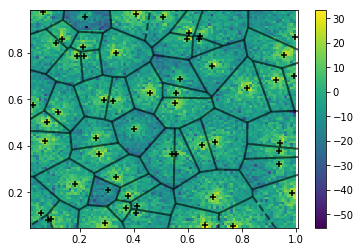

In [14]:
SIR_d = SIR(1, stations, 'd')

>**7)** Critère de la puissance

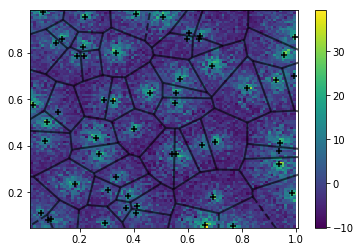

In [15]:
SIR_p = SIR(1, stations, 'p')

Le rendu sur Notebook est petit par rapport à ce que l'on peut obtenir en ligne de commande par exemple.

**7) (bis)** On remarque que la carte de SIR dans les deux cas renvoie des cartes similaires. La différence des couleurs st liée à la mise à l'échelle de l'intensité qui n'est pas la même afin de s'adapter aux valeurs extrêmes de SIR.

# Ajout des utilisateurs 

**8)** On trace le processus et les frontières liées au pavage de Voronoï.

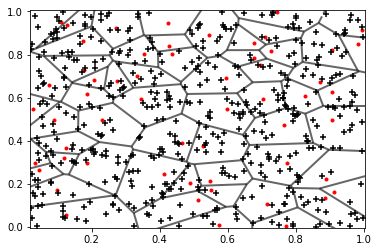

In [44]:
users = proc_poisson(lbda=500, a=1)
vor = Voronoi(stations)
axes = plt.gca()
fig = voronoi_plot_d(vor, ax=axes, show_points=False,
                     show_vertices=False, line_colors='black',
                     line_width=2, line_alpha=0.6, point_size=10)
plt.scatter(stations[:,0], stations[:,1], c="red",marker=".")
plt.scatter(users[:,0], users[:,1], c="black", marker="+")
plt.show()

**9)** 

In [45]:
print("Nombre moyen d'utilisateurs par cellule = ", users.shape[0] / 
      stations.shape[0])

Nombre moyen d'utilisateurs par cellule =  8.87719298245614


Ici, on a déterminé le nombre moyen d'utilisateurs par cellule. En théorie, on a le nombre d'utilisateurs $N$ et $N_s$ le nombre de stations. Le nombre moyen d'utilisateurs est en espérance : $\mathbb{E} \left(\frac{N}{N_s}\right)$. Les deux variables aléatoires sont indépendantes donc : 
$$\mathbb{E}\left(\frac{N}{N_s}\right) = \mathbb{E}(N) \mathbb{E}\left(\frac{1}{N_s}\right) \leq \frac{\mathbb{E}(N)}{\mathbb{E}(N_s)} = \frac{\lambda_u}{\lambda} = 10$$
par l'inégalité de Jensen. En effet, la fonction $y \longmapsto \frac{1}{y}$ est concave sur $]0,+\infty[$

On ne peut a priori pas calculer de valeurs exactes, mais c'est rassurant de savoir que le nombre moyen trouvé est proche de celui du nombre d'utilisateurs dans une cellule GSM , à savoir 8, et qu'il est inférieur à 10.
<br/><br/>

In [19]:
# Simulations pour histogramme : on ne change pas les stations de base
n_iter = 100
nb_user = []
# A chaque itération, on change de répartition d'utilisateurs
for j in range(n_iter):
    users = proc_poisson(lbda=500, a=1)
    # le nombre d'utilisateur dans chaque cellule 
    c_user = count_user(users, stations)
    for u in c_user:
        nb_user.append(u)
nb_user_cell = np.asarray(nb_user)


In [20]:
def hist(x, title, xlabel, ylabel, nb_bins=5):
    plt.hist(x, range = (np.min(x), np.max(x)), bins=nb_bins, 
             color='yellow', edgecolor='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

**10)** Voici l'histogramme du nombre d'utilisateurs par cellule (sur 100 simulations) :

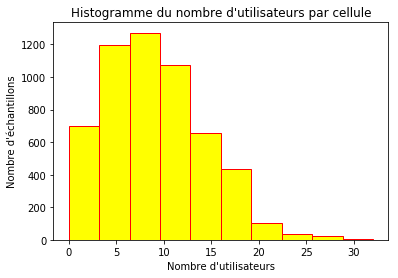

In [22]:
hist(nb_user_cell, "Histogramme du nombre d'utilisateurs par cellule", 
     "Nombre d'utilisateurs", "Nombre d'échantillons", 10)

**11)** L'écart entre les valeurs est dû au fait que l'on a un nombre limite de stations de base. L'histogramme montre qu'il y a peu de chances d'avoir un nombre d'utilisateurs supérieur à $15$ dans une cellule. L'allure de l'histogramme fait penser à une évolution en exponentielle, en particulier à partir de $10$. 

En théorie, en posant quelque soit la cellule, 

$$f_{cell} : \Gamma_{[0,a]^2} \longmapsto \mathbb{R} \quad \xi \longmapsto \sum_{x \in \xi} \mathbb{1}_{\{ x \in \:cell\}}$$ 

On définit alors en appelant fixant la cellule et en appelant donc $f$ la fonction d'intérêt, $$D_x f  : \Gamma_{[0,a]^2} \longmapsto \mathbb{R} \quad \xi \longmapsto f(\xi + \delta_x) - f(\xi)$$

On vérifie les hypothèses du cours avec $\Phi$ le processus de Poisson des utilisateurs.

* Presque sûrement, $D_x f(\Phi) \leq \beta = 1$. En effet, lorsque l'on rajoute un point soit il est dans la cellule soit il ne l'est pas.

* Presque sûrement, $||D_x f(\Phi)||_2 \leq \alpha = a^2 = 1$ par le point précédent.


L'inégalité de concentration nous donne alors le résultat suivant :

$$\mathbb{P}\left(f(\Phi) \geq \mathbb{E}[f(\Phi)] + y \right) \leq exp\left(-\left(\frac{y}{\beta} + \left(\frac{\alpha}{\beta}\right)^2 \right) ln(1 + \frac{\beta \: y}{\alpha^2} + \frac{y}{\beta})\right)$$

L'inégalité nous dit donc que la probabilité de s'éloigner de la moyenne est majorée par un terme qui décroit exponentiellement en y en supposant y ni trop grand ni trop petit, soit : 
$C_1\leq ln(1 + \frac{\beta \: y}{\alpha^2} + \frac{y}{\beta}) \leq C_2$, et donc en notant $N$ le nombre d'utilisateurs dans une cellule, et $\overline{N}$ le nombre moyen.
On a : 

$$\boxed{\mathbb{P}\left(N - \overline{N}\geq  y \right) \leq exp\left(- \Delta y + \tilde{C}\right)}$$

avec $\Delta$ et $\tilde{C}$ des constantes.

Par la loi des grands nombres, notre histogramme doit nous donner asymptotiquement ce résultat, même s'il faut aussi prendre en compte l'erreur dûe aux effets de bords.

<br></br>


**12)** On a écrit des fonctions pour calculer le SIR pour chaque utilisateur.


In [23]:
def SI_user(users, stations, gamma, sigma, dmin = 0.005):
    n = users.shape[0]
    N = (stations.shape)[0]
    S = np.zeros((n,N))
    d = np.zeros((n,N))
    Puiss = np.random.rand(N)   # calcul des puissances des stations de base
    for i in range(n): 
        for j in range(N):
            D = np.linalg.norm(users[i] - stations[j])
            d[i,j] = max(dmin, D)
            S[i,j] = Puiss[j] / (d[i,j]**gamma) \
            * np.random.exponential() * 10**(sigma * np.random.randn() / 10)
    return (S, d)

def SIR_user(users, stations, criteria, gamma=2.5, sigma=2):
    n = users.shape[0]
    N = (stations.shape)[0]
    S_d = SI_user(users, stations, gamma, sigma)
    S = S_d[0]
    d = S_d[1]
    if criteria == 'd':
        bts = np.argmin(d, axis=1)
    else:
        bts = np.argmax(S, axis=1)
    SIR = np.zeros(n)
    for i in range(n):
        signal = S[i,bts[i]]
        interf = 0
        for j in range(N):
            interf += S[i,j]
        SIR[i] = 10 * (np.log10(signal / (interf - signal)))
    return SIR    



**13)** On trace les histogrammes pour chacun des résultats de SIR. Comme on ne travaille pas avec le même nombre de points quand on considère les pixels ou les utilisateurs, les valeurs en ordonnées nous importent peu.  

In [24]:
def SIR_simul(stations, method, n_iter=100, a=1, lbda_u=500):
    if "user" in method:
        users = proc_poisson(lbda_u, a)
        SIR_s = SIR_user(users, stations, method[-1:])
        for j in range(n_iter-1):
            users = proc_poisson(lbda_u, a)
            SIR_s = np.concatenate((SIR_s, SIR_user(users, stations, method[-1:])))
    else:
        if method == 'd':
            SIR_s = SIR(a, stations, 'd', Plot=False)
            for j in range(n_iter-1):
                SIR_s = np.concatenate((SIR_s, SIR(a, stations, 'd', Plot=False)))
        else:
            SIR_s = SIR(a,stations,'p',Plot=False)
            for j in range(n_iter-1):
                SIR_s = np.concatenate((SIR_s, SIR(a, stations, 'p', Plot=False)))
    # vecteur de toutes les valeurs de SIR obtenues quelque soit la position 
    SIR_flat = SIR_s.flatten()
    return SIR_flat
        
    


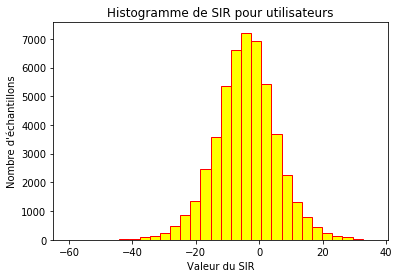

In [25]:
# Simulations pour histogramme : 100 simulations d'utilisateurs dans les cellules 
# (pour un autre processus de Poisson)
stations = proc_poisson(50,1)
SIRs = SIR_simul(stations,'user_d')
hist(SIRs,"Histogramme de SIR pour utilisateurs", "Valeur du SIR", 
     "Nombre d'échantillons", 30)

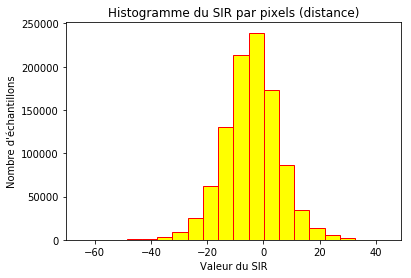

In [26]:
# Simulations pour histogramme : 100 simulations de pixels dans les cellules 
# (un peu long à cause des concaténations de matrices)
SIRd = SIR_simul(stations,'d')
hist(SIRd,"Histogramme du SIR par pixels (distance)", "Valeur du SIR", 
     "Nombre d'échantillons", 20)

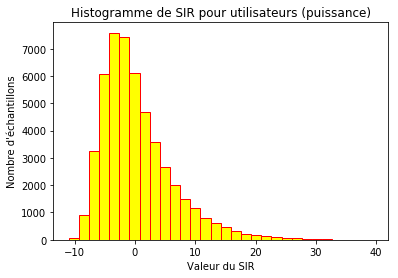

In [27]:
# Simulations pour histogramme : 100 simulations d'utilisateurs dans les cellules 
# (pour un autre processus de Poisson)
stations = proc_poisson(50,1)
SIRs = SIR_simul(stations,'user_p')
hist(SIRs,"Histogramme de SIR pour utilisateurs (puissance)", "Valeur du SIR", 
     "Nombre d'échantillons", 30)

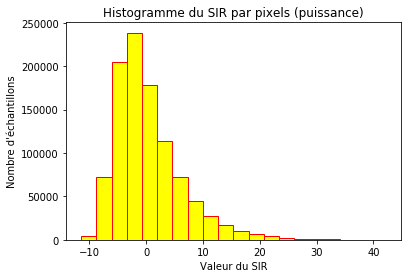

In [28]:
# Simulations pour histogramme : 100 simulations de pixels dans les cellules 
# (un peu long à cause des concaténations de matrices)
SIRp = SIR_simul(stations,'p')
hist(SIRp,"Histogramme du SIR par pixels (puissance)", "Valeur du SIR", 
     "Nombre d'échantillons", 20)

**14)** Ici, on a bien une concentration des valeurs de SIR semblable pour le modèle utilisateur et le modèle pixel pour les deux critères. Les pics centraux correspondent aux mêmes plages de valeurs de SIR. Apparemment, la variance ne change pas trop quand l'on change de modèle. C'est ce qui est attendu.


En conditionnant sur le nombre d'utilisateurs par cellule $N \sim \mathcal{P}(\lambda_u)$, ceux-ci se répartissent de façon uniforme sur le carré de côté $a$, et les résultats sur le SIR devraient se rapprocher du cas des pixels(avec le même nombre). 

Donc on a : $$\mathbb{E}[SIR_{user}] = \sum_{i=1}^{\infty} \mathbb{P}(N = k) \mathbb{E}[SIR_{user}|N=k]$$

avec $\mathbb{E}[SIR_{user}|N=k] \simeq \mathbb{E}[SIR_{k\:pixels}] \simeq \mathbb{E}[SIR_{M\:pixels}]$ avec $M$ le nombre de pixels dans le réseau carré. 
 
Or, d'après les remarques précédentes : $$\mathbb{E}[SIR_{user}] \simeq \sum_{i=1}^{20} \mathbb{P}(N = k) \mathbb{E}[SIR_{user}|N=k] \simeq \mathbb{E}[SIR_{M\:pixels}]$$

On a aussi le même raisonnement pour la variance, et de façon générale pour tous moments de la variable aléatoire $SIR$.

<br></br>

**15)**

## Conclusion 


Dans l'idéal, la meilleure solution semble être celle des utilisateurs, car le SIR est plus réaliste que dans le cas des pixels. 

Or avec les pixels, on arrive à reproduire la forme de la courbe de la répartition des valeurs de SIR, et les valeurs moyennes et écart-type semblent conservées à vue d'oeil. **Surtout on peut cartographier l'espace.** 

Si on voulait faire la même chose avec le modèle utilisateur, il faudrait bien plus de temps. En effet, le nombre de points tirés doit être suffisamment grand pour que l'on ait l'impression de paver l'espace. Une bonne valeur de ce nombre serait le nombre de pixels dans nos simulations, $M = 10^6$. 
Même avec $M = 10^4$, par l'inégalité de Bienaymé-Chebyshev :
$$\mathbb{P}(N  > M) \leq \mathbb{P}(|N - \lambda_u| > M - \lambda_u) \leq \frac{\lambda_u}{(M - \lambda_u)^2} \leq 6.10^{-6}$$

On a donc très peu de chances d'avoir autant de points en générant un processus de Poisson. 

# Annexe 

**Fonction pour tracer la carte de SIR :**

In [29]:
from __future__ import division, print_function, absolute_import

import numpy as np
from scipy._lib.decorator import decorator as _decorator


def _adjust_bounds2(ax, points):
    ptp_bound = points.ptp(axis=0)
    ax.set_xlim(points[:,0].min() - 0.01*ptp_bound[0],
                points[:,0].max() + 0.01*ptp_bound[0])
    ax.set_ylim(points[:,1].min() - 0.01*ptp_bound[1],
                points[:,1].max() + 0.01*ptp_bound[1])

def voronoi_plot_d(vor, ax, **kw):

    from matplotlib.collections import LineCollection

    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")

    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.plot(vor.points[:,0], vor.points[:,1], '.', markersize=point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:,0], vor.vertices[:,1], 'o')

    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)

    finite_segments = []
    infinite_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[i] + direction * ptp_bound.max()

            infinite_segments.append([vor.vertices[i], far_point])

    ax.add_collection(LineCollection(finite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='solid'))
    ax.add_collection(LineCollection(infinite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='dashed'))

    _adjust_bounds2(ax, vor.points)
    
    return ax